**Autoencoder (AE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from data_preprocessor import data_preprocessor as preproc
from data_splitter import fixed_splitter as fs
from model_manager import model_generator, model_trainer, model_storage
from grapher import graph_generator as gg

2025-07-24 11:26:48.754852: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 11:26:48.766249: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 11:26:48.804513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753381608.868267 4132117 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753381608.879089 4132117 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753381608.915081 4132117 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Opening the trainer_config.json file:

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
model_type = 'AE'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing & Splitting**

---

This block will open and validate the background data file. It must contain the directory "Particles" within it in order for us to continue. It will then save it into a numpy array to be used for model training.

In [3]:
preprocessed_data = preproc.get_data(train_config)

Ato4l = preproc.get_data(train_config, "Ato4l_lepFilter_13TeV")
hToTauTau = preproc.get_data(train_config, "hToTauTau_13TeV_PU20")
hChToTauNu = preproc.get_data(train_config, "hChToTauNu_13TeV_PU20")
leptoquark = preproc.get_data(train_config, "leptoquark_LOWMASS_lepFilter_13TeV")

Ato4l = preproc.normalize_data(Ato4l)
hToTauTau = preproc.normalize_data(hToTauTau)
hChToTauNu = preproc.normalize_data(hChToTauNu)
leptoquark = preproc.normalize_data(leptoquark)

signal_data = np.concatenate([
    Ato4l, 
    hToTauTau,
    hChToTauNu,
    leptoquark
])

data_train, data_validate, data_test = fs.generate_fixed_trainingdata_split(train_config, preprocessed_data, True)

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (70000, 57)


**Model Initialization**

---

Initialize an instance of the model

In [4]:
model = model_generator.create_model(train_config, "AE")

2025-07-24 11:30:19.838785: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_32 (Dense)              │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_16 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,418 (9.45 KB)

 Trainable params: 2,418 (9.45 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,473 (9.66 KB)

 Trainable params: 2,473 (9.66 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

---

In [5]:
model, history = model_trainer.train_model(train_config, model, data_train, data_validate)
# gg.generate_loss_vs_epoch(train_config, history)

Training model generic
Epoch 1/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.2298 - val_loss: 0.1686 - learning_rate: 0.0010
Epoch 2/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1655 - val_loss: 0.1587 - learning_rate: 0.0010
Epoch 3/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1586 - val_loss: 0.1579 - learning_rate: 0.0010
Epoch 4/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1581 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 5/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1578 - val_loss: 0.1572 - learning_rate: 0.0010
Epoch 6/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1574 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 7/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1571 - val_loss: 0.1565 - learning_rate: 0.0010
Epoch 8/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1568 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 9/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1567 - val_loss

**Model Evaluation**

---

Processing the signal data

In [16]:
reconstructed_background = model(data_test).numpy()
reconstructed_Ato4l = model(Ato4l).numpy()
reconstructed_hToTauTau = model(hToTauTau).numpy()
reconstructed_hChToTauNu = model(hChToTauNu).numpy()
reconstructed_leptoquark = model(leptoquark).numpy()

background_scores = ((reconstructed_background-data_test)**2)
Ato4l_scores = ((reconstructed_Ato4l - Ato4l)**2)
hToTauTau_scores = ((reconstructed_hToTauTau - hToTauTau)**2)
hChToTauNu_scores = ((reconstructed_hChToTauNu - hChToTauNu)**2)
leptoquark_scores = ((reconstructed_leptoquark - leptoquark)**2)


background_scores = np.mean(background_scores,axis=1,keepdims=True)
Ato4l_scores = np.mean(Ato4l_scores,axis=1,keepdims=True)
hToTauTau_scores = np.mean(hToTauTau_scores,axis=1,keepdims=True)
hChToTauNu_scores = np.mean(hChToTauNu_scores,axis=1,keepdims=True)
leptoquark_scores = np.mean(leptoquark_scores,axis=1,keepdims=True)

background_scores = background_scores[:50000]
Ato4l_scores = Ato4l_scores[:50000]
hToTauTau_scores = hToTauTau_scores[:50000]
hChToTauNu_scores = hChToTauNu_scores[:50000]
leptoquark_scores = leptoquark_scores[:50000]




Generate ROC and loss histograms, seeing if we can get that anomaly score to work...

In [17]:
# gg.generate_roc_curve(train_config, truth_values, scores)


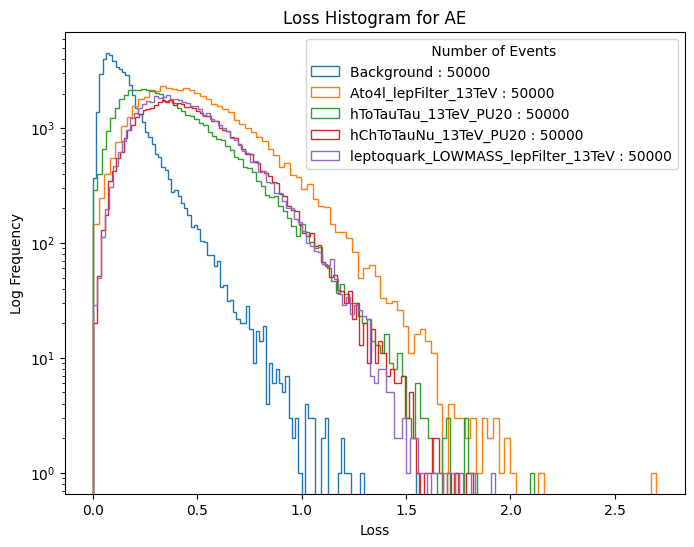

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, histtype='step',bins=train_config["outputs"]["bins"], label='Background : {}'.format(len(background_scores)))
plt.hist(Ato4l_scores, histtype='step',bins=train_config["outputs"]["bins"], label='Ato4l_lepFilter_13TeV : {}'.format(len(Ato4l_scores)))
plt.hist(hToTauTau_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hToTauTau_13TeV_PU20 : {}'.format(len(hToTauTau_scores)))
plt.hist(hChToTauNu_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hChToTauNu_13TeV_PU20 : {}'.format(len(hChToTauNu_scores)))
plt.hist(leptoquark_scores,histtype='step', bins = train_config["outputs"]["bins"], label='leptoquark_LOWMASS_lepFilter_13TeV : {}'.format(len(leptoquark_scores)))
plt.xlabel('Loss')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.title("Loss Histogram for AE")
plt.legend(title=" Number of Events")
# plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
        # train_config["outputs"]["date_time_format"]) + "_Histogram.png"), format="png", bbox_inches="tight")
plt.show()

In [19]:
# TODO
# Save model if it is interesting